In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.set_cmap('viridis')
import scipy.io as sio
import time
import sys
sys.path.append('/home/matsui-k/projects/d-rcn')
from scripts.core import TN_utils, models, compiling, optimizers, blocks
reload(TN_utils)
reload(models)
reload(blocks)

Using gpu device 1: Tesla K40m (CNMeM is disabled, CuDNN not available)


<module 'scripts.core.blocks' from '/home/matsui-k/projects/d-rcn/scripts/core/blocks.pyc'>

In [4]:
import theano
import theano.tensor as T

In [5]:
def multi_order_mix(tensor_list, j_input_list, j_output, n_input_tensors_list, n_output_tensors):
    assert len(tensor_list) == len(j_input_list) == len(n_input_tensors_list)
    coupling_list = [(l1, l2) for l1 in j_input_list for l2 in j_input_list if abs(l1-l2) <= j_output <= l1+l2 and l1 <= l2]
    print coupling_list

    output_list = []
    weight_list = []
    bias_list = []
    for coupling in coupling_list:
        j1 = coupling[0]
        j2 = coupling[1]
        index_j1 = j_input_list.index(j1)
        index_j2 = j_input_list.index(j2)

        W1 = models.make_weight(n_input_tensors_list[index_j1], n_output_tensors)
        W2 = models.make_weight(n_input_tensors_list[index_j2], n_output_tensors)
        weight_list.append(W1)
        weight_list.append(W2)
        bias = models.make_bias(n_output_tensors)
        bias_list.apped(bias)
        
        h1 = blocks.superpose_vectors(tensor_list[index_j1], W1)
        h2 = blocks.superpose_vectors(tensor_list[index_j2], W2)

        h_tc = blocks.tensor_coupling(h1, h2,  j_output, j1, j2)

        h_na = blocks.activate_norm(h_tc, bias)[0]

        output_list.append(h_na)

    return T.concatenate(output_list, axis=2), weight_list, bias_list

In [ ]:
data_list = []
for order in [0, 1, 2]:
    fe, gt, mask, vol_shape = TN_utils.load_hardi(order)
    data, norm, gt_norm = TN_utils.preprocess(fe, gt, mask)
    data_list.append(data[0][:10])
for data in data_list:
    print data.shape
D0 = TN_utils.wignerD(0)
D2 = TN_utils.wignerD(2)
D4 = TN_utils.wignerD(4)

[(0, 0), (2, 2), (4, 4)]
order 0 0
index 0 0
order 2 2
index 1 1
order 4 4
index 2 2


(array([  1.,   0.,   5.,   5.,  26.,  75.,   5.,   1.,   1.,   1.]),
 array([ -4.65661287e-10,  -3.72529030e-10,  -2.79396772e-10,
         -1.86264515e-10,  -9.31322575e-11,   0.00000000e+00,
          9.31322575e-11,   1.86264515e-10,   2.79396772e-10,
          3.72529030e-10,   4.65661287e-10]),
 <a list of 10 Patch objects>)

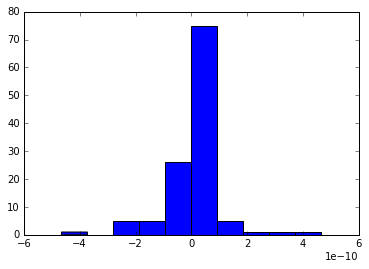

In [47]:
j_input_list = [0, 2, 4]
j_output = 0
tensor_list = [T.tensor3() for i in range(len(l_input_list))]
n_input_tensors_list = [31, 43, 37]
n_output_tensors = 2

out = multi_order_mix(tensor_list, j_input_list, j_output, n_input_tensors_list, n_output_tensors)

f = theano.function(inputs=tensor_list,
                    outputs=[out])

a = f(np.concatenate([data_list[0], np.zeros_like(data_list[0])], axis=1), data_list[1], data_list[2])[0]
b = f(TN_utils.rotate_tensor(np.concatenate([data_list[0], np.zeros_like(data_list[0])], axis=1), D0), 
        TN_utils.rotate_tensor(data_list[1], D2),
      TN_utils.rotate_tensor(data_list[2], D4))[0]

plt.hist((b - TN_utils.rotate_tensor(a, D0)).flatten())

[(0, 2), (2, 2), (2, 4), (4, 4)]


(array([   1.,    0.,    3.,   11.,  348.,  429.,    5.,    2.,    0.,    1.]),
 array([ -1.39698386e-09,  -1.11758709e-09,  -8.38190317e-10,
         -5.58793545e-10,  -2.79396772e-10,   0.00000000e+00,
          2.79396772e-10,   5.58793545e-10,   8.38190317e-10,
          1.11758709e-09,   1.39698386e-09]),
 <a list of 10 Patch objects>)

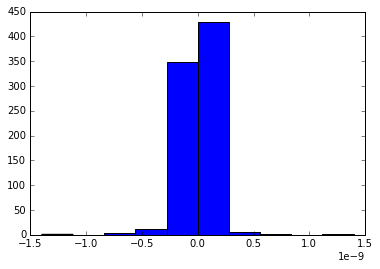

In [52]:
j_input_list = [0, 2, 4]
j_output = 2
tensor_list = [T.tensor3() for i in range(len(l_input_list))]
n_input_tensors_list = [31, 43, 37]
n_output_tensors = 2

out = blocks.multi_order_mix(tensor_list, j_input_list, j_output, n_input_tensors_list, n_output_tensors)[0]

f = theano.function(inputs=tensor_list,
                    outputs=[out])

a = f(np.concatenate([data_list[0], np.zeros_like(data_list[0])], axis=1), data_list[1], data_list[2])[0]
b = f(TN_utils.rotate_tensor(np.concatenate([data_list[0], np.zeros_like(data_list[0])], axis=1), D0), 
        TN_utils.rotate_tensor(data_list[1], D2),
      TN_utils.rotate_tensor(data_list[2], D4))[0]

plt.hist((b - TN_utils.rotate_tensor(a, D2)).flatten())

[(0, 4), (2, 2), (2, 4), (4, 4)]
order 0 4
index 0 2
order 2 2
index 1 1
order 2 4
index 1 2
order 4 4
index 2 2


(array([  3.00000000e+00,   1.00000000e+00,   1.20000000e+01,
          4.30000000e+01,   1.00400000e+03,   3.35000000e+02,
          3.40000000e+01,   6.00000000e+00,   1.00000000e+00,
          1.00000000e+00]),
 array([ -8.14907253e-10,  -6.46105036e-10,  -4.77302819e-10,
         -3.08500603e-10,  -1.39698386e-10,   2.91038305e-11,
          1.97906047e-10,   3.66708264e-10,   5.35510480e-10,
          7.04312697e-10,   8.73114914e-10]),
 <a list of 10 Patch objects>)

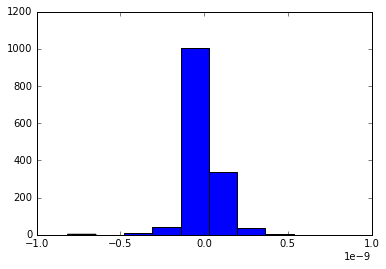

In [45]:
j_input_list = [0, 2, 4]
j_output = 4
tensor_list = [T.tensor3() for i in range(len(l_input_list))]
n_input_tensors_list = [31, 43, 37]
n_output_tensors = 2

out = multi_order_mix(tensor_list, j_input_list, j_output, n_input_tensors_list, n_output_tensors)

f = theano.function(
                    inputs=tensor_list,
                    outputs=[out])

a = f(np.concatenate([data_list[0], np.zeros_like(data_list[0])], axis=1), data_list[1], data_list[2])[0]
b = f(TN_utils.rotate_tensor(np.concatenate([data_list[0], np.zeros_like(data_list[0])], axis=1), D0), 
        TN_utils.rotate_tensor(data_list[1], D2),
      TN_utils.rotate_tensor(data_list[2], D4))[0]

plt.hist((b - TN_utils.rotate_tensor(a, D4)).flatten())